# NNMF with cross-validated number of components

INFO:


TODO:
- plot repeated nnmf_cv results and find cutoff at CI95

In [4]:
# Library/module setup

import sys
sys.path.append('./ext/')

from cv import * # NNMF cross-validation functions

from scipy import stats
import scipy.io as sio # data input/output

import matplotlib.pyplot as plt # plotting lib
# %matplotlib inline
import matplotlib.gridspec as gridspec

%load_ext autoreload
%autoreload 2

# Load data

In [6]:
# Load PSTH data (.mat file)
orig_data = sio.loadmat('../data/nnmf_best.mat')
sio.whosmat('../data/nnmf_best.mat')

[('A', (641, 25), 'double'),
 ('D_res', (100, 1), 'double'),
 ('X', (641, 815), 'double'),
 ('Y', (25, 815), 'double'),
 ('k_best', (1, 1), 'double'),
 ('psth', (1, 1), 'struct')]

In [3]:
# Extract PSTH data
data = orig_data['psth']['psth'][0,0] # PSTH array is in nnmf_best.psth.psth
print('data: firing rate PSTH of %i cells x %i tPoints' % data.shape)

data: firing rate PSTH of 815 cells x 641 tPoints


In [4]:
# Load cross-validated NNMF errors per rank
dat       = np.load('../data/nnmf_cv_err_per_comp-all.npy').item()
test_err  = dat['test_err']
train_err = dat['train_err']
seeds     = dat['seeds']
print(len(train_err), len(test_err), len(seeds))

14012 14012 14012


# Plot

In [85]:
def defaultPlotPars():
    """Defines default plot parameters by changing rcParams.
    TODO: 
        - See if need to output other plot params that cannot be changed in rcParams. 
        - Allow for dict input of parameters.
    """
    from pylab import rcParams as rc

    plot_par = {'font.size': 13.0,
           'axes.linewidth': 1,
           'axes.labelsize': 'large',
           'axes.titlesize': 'large',
           'xtick.labelsize': 'medium',
           'ytick.labelsize': 'medium',
           'svg.fonttype': 'none', # render text as text in .svg savefig (otherwise path)
           'pdf.fonttype': 42, # render text as text in .pdf savefig (otherwise path)
           }
    rc.update(plot_par)
    
    return rc, plot_par

In [86]:
rc, plot_par = defaultPlotPars()

## Plot error curves and error ratio curve

In [7]:
def nnmf_statistics(errs, print_info=False):
    """nnmf_statistics(errs,  print_info=False):
    Calculate some statistics on cross-validated NNMF MSE results, used in plot_nnmf_cv_err().
    Argument: 
        errs: Error statistic and associated rank; tuple: (rank, error)
    Returns: 
        err, rank, mean_err, sd_err, N, ci_err, min_err, min_err_mean
    """

    err, rank = np.array([i[1] for i in errs]), np.array([i[0] for i in errs])
    ranks = np.unique(np.unique([i[0] for i in errs]))

    # Mean, SD, CI
    mean_err, sd_err = [np.mean(err[rnk==rank]) for rnk in ranks], [np.std(err[rnk==rank]) for rnk in ranks]
    N = [len(err[rnk==rank]) for rnk in ranks]
    ci_err    = stats.t.interval(0.95, df=N, loc=mean_err, scale = sd_err/np.sqrt(N))
    #     ci_train_norm = stats.norm.interval(0.95, loc=mean_train, scale = sd_train/np.sqrt(N))

    # Find rank / number of components with smallest MSE
    min_err = errs[np.argmin([x[1] for x in errs])] # min(MSE) single data point
    min_err_mean = (idx, val) = np.argmin(mean_err)+1, np.min(mean_err) # min(mean_MSE)
    
    if print_info:
        print('Number of components with single minimal MSE: %i (MSE: %f)' % (min_err[0], min_err[1]))
        print('Number of components with mean minimal MSE: %i (MSE: %f)' % (min_err_mean[0], min_err_mean[1]))

    return err, rank, ranks, mean_err, sd_err, N, ci_err, min_err, min_err_mean

In [8]:
## Plot cross-validated train vs test errors
def plot_nnmf_cv_err(train_err, test_err, ax=None, xlim=(0,70), ylim=(0,0.05), show_opt_rank='mean', save_fig=False):
    '''plot_nnmf_cv_err(train_err, test_err)
    Plots cross-validated NNMF errors for training vs test set.
    Arguments:
        train_err, test_err: tuples: training and test errors per rank (rank, err)
        ax: axis-object: axis to be used (for embedding into larger plots), otherwise created on the spot
        xlim, ylim: tuples: x/y-axis limits
        show_opt_rank: string: show optimal rank criteria. OPTIONS: 'single', 'mean', 'both', None
        save_fig: boolean: save figure or not.
    Returns:
        ax: axis object: axis
    TODO: decide on vertical line par
    '''
    ## Pars    
    cmap = plt.cm.Set1(np.linspace(0,1,9)) # load colormap: Dark2
    tr_col, te_col = cmap[1], cmap[0] #cmap[0], cmap[1]
    
    ## Calculations
    print('Training set:')
    _, _, ranks, mean_test, _, N, ci_test, min_test, min_test_mean = nnmf_statistics(test_err, print_info=True)
    print('Test set:')    
    _, _, _, mean_train, _, _, ci_train, _, _ = nnmf_statistics(train_err, print_info=True)

    ## Plot
    if ax is None: # create fig & ax if not specified
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Single data points
    ax.plot(*list(zip(*train_err)), linestyle='', marker='o', color=tr_col, markerfacecolor='None', alpha=0.1)
    ax.plot(*list(zip(*test_err)), linestyle='', marker='o', color=te_col, markerfacecolor='None', alpha=0.1)
    # Means
    ax.plot(ranks, mean_train, color=tr_col, label='mean(Train)')
    ax.plot(ranks, mean_test, color=te_col, label='mean(Test)')
    # CIs
    ax.fill_between(ranks, ci_train[0], ci_train[1], facecolor=tr_col, alpha=0.4, label='CI$_{95}$(Train)')
    ax.fill_between(ranks, ci_test[0], ci_test[1], facecolor=te_col, alpha=0.4, label='CI$_{95}$(Test)')
    
    ax.set_ylabel('Mean Squared Error')
    ax.set_xlabel('Number of components')
    ax.set_title('Cross-validated NNMF errors \n N$_{repetitions}$ = %i' %int(np.mean(N)))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    plt.tight_layout()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Mark optimal rank criteria
    if show_opt_rank=='single' or show_opt_rank=='all':
        ax.axvline(min_test[0], color='k', dashes=[2,2]) # optimal rank single
        ax.text(min_test[0]-1, ax.get_ylim()[0], 'min(MSE$_{single}$) \nN = %i' % min_test[0],
                verticalalignment='bottom', horizontalalignment='right')
    if show_opt_rank=='mean' or show_opt_rank=='all':
        ax.axvline(min_test_mean[0], color='k', dashes=[2,2]) # optimal rank mean
        ax.text(min_test_mean[0]-1, ax.get_ylim()[0], 'min(MSE$_{mean}$) \nN = %i' % min_test_mean[0],
                verticalalignment='bottom', horizontalalignment='right')
    
#     fig = plt.gcf()
#     fig.set_size_inches(8,8)
    
#     plt.show() # calling plt.show() interferes with further plotting
    if save_fig:
        fig.savefig('../figures/nnmf_cv_err_curve.pdf')
        fig.savefig('../figures/nnmf_cv_err_curve.png')
        
    return ax

In [9]:
## Plot ratio of cross-validated train vs test errors

def plot_nnmf_cv_err_ratio(train_err, test_err, ax=None, show_opt_rank='mean', save_fig=False):
    '''plot_nnmf_cv_err_ratio(train_err, test_err, save_fig=False):
    Plots ratio of cross-validated NNMF errors for training vs test set.
    Argumements:
        train_err, test_err: tuples: training and test errors per rank (rank, err)
        ax: axis-object: axis to be used (for embedding into larger plots), otherwise created on the spot
        save_fig: boolean: save figure or not.    
    Returns:
        ax: axis object: axis
    '''
    # Pars
    ratio_cut = 1.1 # cutoff line for ratio(test/train)
    ylim_cut = 3
    
    ## Calculations
    tr, rank, ranks, _, _, _, _, _, _ = nnmf_statistics(train_err)
    te, _, _, mean_test, _, _, _, min_test, min_test_mean = nnmf_statistics(test_err)
    
    # Get ratio of cross-validated train vs test errors
    ratio = [i / j for i,j in zip(te,tr)]
    ratio = list(zip(rank, ratio))
    _, _, _, mean_ratio, _, _, ci_ratio, _, _ = nnmf_statistics(ratio)
    
    ## Plot
    if ax is None: # create fig & ax if not specified
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
#     ax.plot(*list(zip(*ratio)), linestyle='', marker='o', color='purple', markerfacecolor='None', alpha=0.3) # Single data
    ax.plot(mean_ratio, 'o-', color='purple', label='mean(ratio)') # Mean
    ax.fill_between(ranks-1, ci_ratio[0], ci_ratio[1], facecolor='purple', alpha=0.4, label='CI$_{95}$(ratio)') # CI
    # ax.set_ylabel('$MSE_{test}$ / $MSE_{train}$')
    ax.set_ylabel('$\\frac{MSE_{test}}{MSE_{train}}$', Fontsize=20)
    ax.set_xlabel('Number of components')
    ax.set_title('Corresponding error ratios')
    ax.set_ylim(0, ylim_cut)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Mark optimal rank criteria
    if show_opt_rank=='single' or show_opt_rank=='all':
        ax.axvline(min_test[0], color='k', dashes=[2,2]) # optimal rank single
        ax.text(min_test[0]-1, ax.get_ylim()[0], 'min(MSE$_{single}$) \nN = %i' % min_test[0], Fontsize=12,
                verticalalignment='bottom', horizontalalignment='right')
    if show_opt_rank=='mean' or show_opt_rank=='all':
        ax.axvline(min_test_mean[0], color='k', dashes=[2,2]) # optimal rank mean
        ax.text(min_test_mean[0]-1, ax.get_ylim()[0], 'min(MSE$_{mean}$) \nN = %i' % min_test_mean[0], Fontsize=12,
                verticalalignment='bottom', horizontalalignment='right')

#     ax.axhline(ratio_cut, color='k', dashes=[2,2]) # horizontal line for ratio cut-off
#     ax.text(ax.get_xlim()[1], ratio_cut, 'ratio = %.1f'%ratio_cut,
#             Fontsize=12, verticalalignment='bottom', horizontalalignment='right')
    ax.axhline(mean_ratio[min_test_mean[0]], color='k', dashes=[2,2]) # horizontal line for ratio at optimal rank mean
    ax.text(ax.get_xlim()[1], mean_ratio[min_test_mean[0]], 'ratio = %.1f'%mean_ratio[min_test_mean[0]],
            Fontsize=12, verticalalignment='bottom', horizontalalignment='right')

    ax.legend()
    plt.tight_layout()
#     plt.show() # calling plt.show() interferes with further plotting

    if save_fig:
        fig.savefig('../figures/nnmf_cv_err_ratio_curve.pdf')
        fig.savefig('../figures/nnmf_cv_err_ratio_curve.png')
        
    return ax

In [14]:
def plot_nnmf_cv_curves(save_fig=False):
    '''plot_nnmf_cv_curves():
    Combines plots of cross-validated NNMF (1) errors for training vs test set and (2) their ratio.'''
    fig, [ax1, ax2] = plt.subplots(1,2, figsize=(14, 7))

    plot_nnmf_cv_err(train_err, test_err, ax=ax1)
    plot_nnmf_cv_err_ratio(train_err, test_err, ax=ax2)
    
    if save_fig:
        fig.savefig('../figures/nnmf_cv_err_and_ratio_curves.pdf')
        fig.savefig('../figures/nnmf_cv_err_and_ratio_curves.png')

    plt.show()

Training set:
Number of components with single minimal MSE: 66 (MSE: 0.006721)
Number of components with mean minimal MSE: 33 (MSE: 0.007741)
Test set:
Number of components with single minimal MSE: 70 (MSE: 0.003854)
Number of components with mean minimal MSE: 70 (MSE: 0.003912)


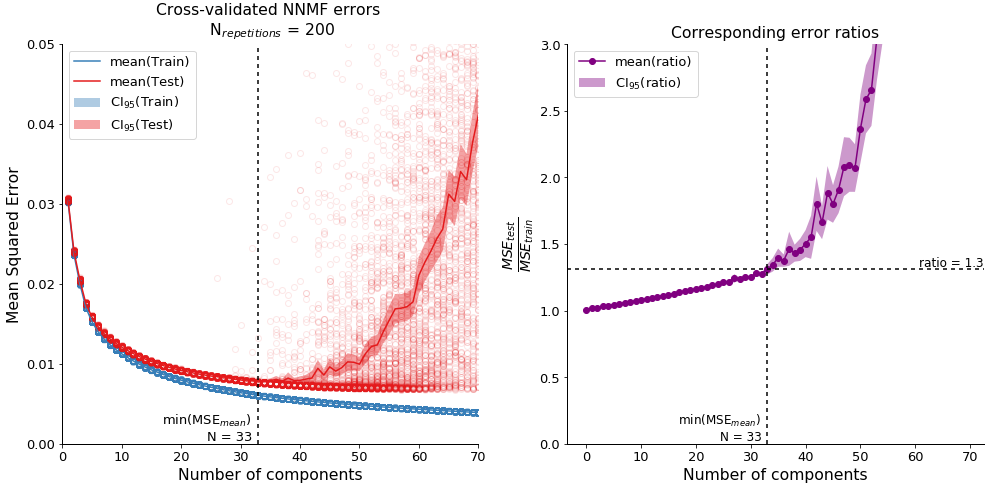

In [87]:
 # Plot both curves
plot_nnmf_cv_curves(save_fig=True)

Training set:
Number of components with single minimal MSE: 66 (MSE: 0.006721)
Number of components with mean minimal MSE: 33 (MSE: 0.007741)
Test set:
Number of components with single minimal MSE: 70 (MSE: 0.003854)
Number of components with mean minimal MSE: 70 (MSE: 0.003912)


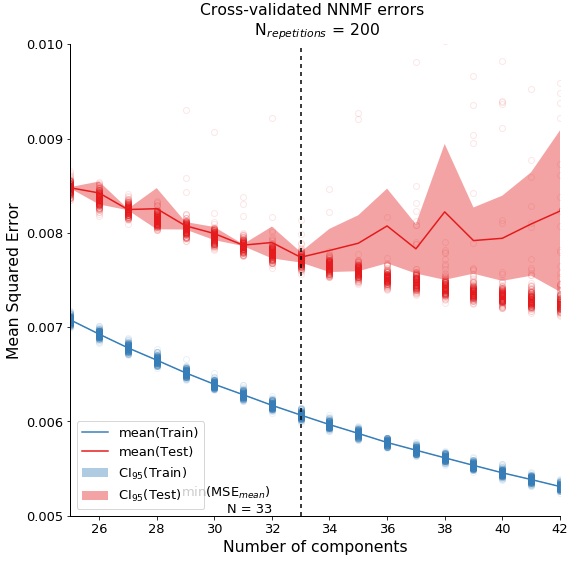

In [84]:
# Zoom in on optimal region
ax = plot_nnmf_cv_err(train_err, test_err, xlim=(25,42), ylim=(0.005,0.01), show_opt_rank='mean')
plt.show()

## Plot components

In [53]:
def plot_nnmf_comp(comp, ax=None, col='k'):
    '''Plots single NNMF components.'''
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(16,4))
    
    ax.plot(comp.T, color=col)
    ax.axis('off')
    

In [76]:
def plot_nnmf_comp_all(comps):

    n = comps.shape[0]

    fig, axes = plt.subplots(n, 1, figsize=(16,n/2))
        
    cmap = plt.cm.nipy_spectral(np.linspace(0,1,n)) # load colormap, CANDIDATES: Set1, jet
#     np.random.shuffle(cmap) # [np.random.randint(0,n,1)[0]]

    for i in range(n):
        plot_nnmf_comp(comps[i], ax=axes[i], col=cmap[i]) # call single component plotting function

    plt.show()

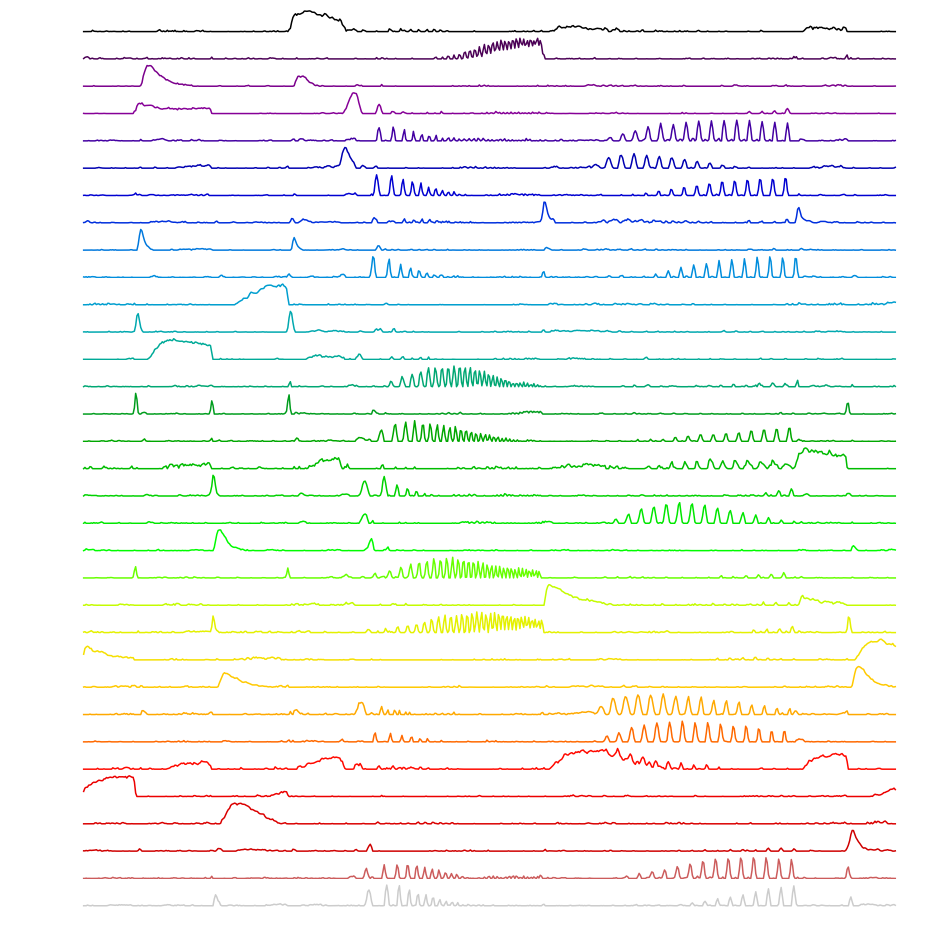

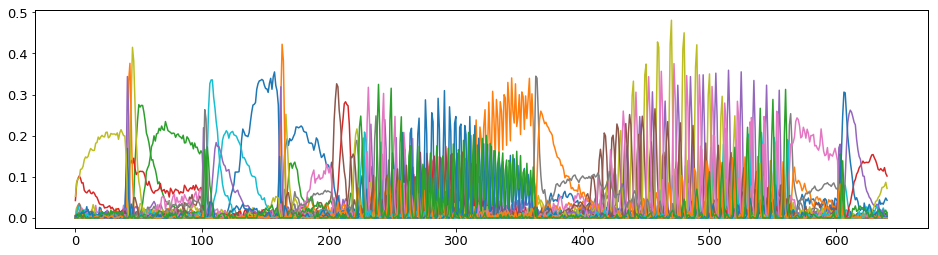

In [81]:
# Save components for plotting
do_plot_comps = True
if do_plot_comps:
    # Load
    model = sio.loadmat('../data/nnmf_cv_model.mat')
    
    # Plot components separated
    plot_nnmf_comp_all(model['Vt'])
    
    # Plot components salad
    fig, ax = plt.subplots(1, 1, figsize=(16,4))
    ax.plot(model['Vt'].T)
    plt.show()

# TESTS

In [2]:
# Do dry run with artificial data generated by plot_nmf()
plot_nmf()

Fitting model with rank 1/7 ...
Fitting model with rank 2/7 ...
Fitting model with rank 3/7 ...
Fitting model with rank 4/7 ...
Fitting model with rank 5/7 ...
Fitting model with rank 6/7 ...
Fitting model with rank 7/7 ...
DONE.


In [24]:
# Parameters
# N, R = 150, 4
# noise = .8
repetitions = 2
ranks = np.arange(1, 3)

In [5]:
# Initialize problem
# U = np.random.rand(N, R)
# Vt = np.random.rand(R, N)
# data = np.dot(U, Vt) + noise*np.random.rand(N, N)
# train_err, test_err = [], []

In [25]:
# Fit NNMF models w various k components

train_err, test_err = [], [] # initialize problem

t = time.time() # get execution time
for rnk, _ in itertools.product(ranks, range(repetitions)):
    print('Fitting model with rank %i/%i ...' % (rnk, ranks[-1]))
    tr, te = cv_pca(data, rnk, nonneg=True)[2:]
    train_err.append((rnk, tr))
    test_err.append((rnk, te))
    
print('DONE! Execution time: %i s.' % round(time.time() - t))

Fitting model with rank 1/2 ...
Fitting model with rank 1/2 ...
Fitting model with rank 2/2 ...
Fitting model with rank 2/2 ...
DONE! Execution time: 91 s.


In [9]:
tr, te = cv_pca(data, 30, nonneg=True)[2:]